<a href="https://colab.research.google.com/github/Srujanx/NHL_logo_prediction/blob/main/TML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

In [2]:
base_dir = '/content'
aug_dir = '/content/aug_logos'

In [3]:
teams = ['maple_leaves' , 'bruins' , 'penguins' , 'canadiens' , 'blackhawks']

In [4]:
os.makedirs(aug_dir , exist_ok = True)
for i in teams:
  os.makedirs(os.path.join(aug_dir , i) , exist_ok = True)



In [5]:
data_aug = ImageDataGenerator(rotation_range= 30 , width_shift_range= 0.2 ,
                              height_shift_range = 0.2 , shear_range = 15 , zoom_range = 0.2,
                              horizontal_flip = True , brightness_range = [0.7 , 1.3] ,
                              fill_mode = 'nearest'

)

In [6]:
original = 0
augmented = 0

for i in teams:
  team_dir = os.path.join(base_dir , i)
  aug_team_dir = os.path.join(aug_dir , i)

  images = [f for f in os.listdir(team_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
  original = original + len(images)

  for j,k in enumerate(images):
    img_path = os.path.join(team_dir , k)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (128 , 128))
    cv2.imwrite(os.path.join(aug_team_dir , f'{i}_orig_{j:03d}.jpg'),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img_array = img.reshape((1,) + img.shape)
    l = 0
    for b in data_aug.flow(img_array , batch_size = 1):
      aug_img = b[0].astype('uint8')
      cv2.imwrite(os.path.join(aug_team_dir, f'{i}_aug_{j:03d}_{l:02d}.jpg'),
                       cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
      l = l + 1
      if l >= 15:
        break
  team_total = len(os.listdir(aug_team_dir))
  augmented = augmented + team_total



In [7]:
original

165

In [8]:
augmented

2640

In [9]:
augmented/original

16.0

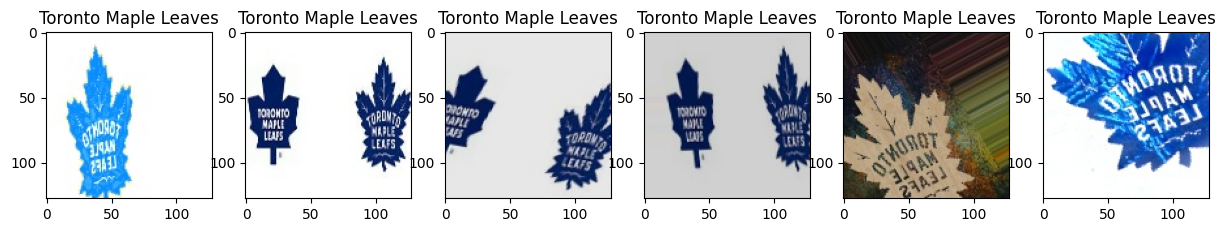

In [10]:
import matplotlib.pyplot as plt
team = 'maple_leaves'
samples = 6

aug_team_dir = os.path.join(aug_dir , team)
images = os.listdir(aug_team_dir)[:samples]
fig, axes = plt.subplots(1, samples, figsize=(15, 3))

for m, n in enumerate(images):
    img_path = os.path.join(aug_team_dir, n)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[m].imshow(img)
    axes[m].set_title('Toronto Maple Leaves')

plt.show()

In [11]:
data_aug = ImageDataGenerator(rescale = 1/255 , validation_split = 0.2)

In [12]:
train_data = data_aug.flow_from_directory( aug_dir , target_size = (128,128)
, batch_size = 32 , class_mode = 'categorical' , subset = 'training' , shuffle = True)

Found 2113 images belonging to 5 classes.


In [13]:
test_data = data_aug.flow_from_directory( aug_dir , target_size = (128,128)
, batch_size = 32 , class_mode = 'categorical' , subset = 'validation' , shuffle = False)


Found 527 images belonging to 5 classes.


In [14]:
len(train_data.class_indices)

5

In [15]:
len(test_data)

17

In [16]:
test_data.samples

527

In [17]:
train_data.samples

2113

In [18]:
from tensorflow.keras.applications import VGG16

In [19]:
model = VGG16( weights = 'imagenet' , input_shape = (128 , 128 , 3) ,
              include_top = False)
model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
from tensorflow.keras import models , layers
model1 = models.Sequential([
    model
])
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(256 , activation = 'relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128 , activation = 'relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(5, activation = 'softmax'))
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


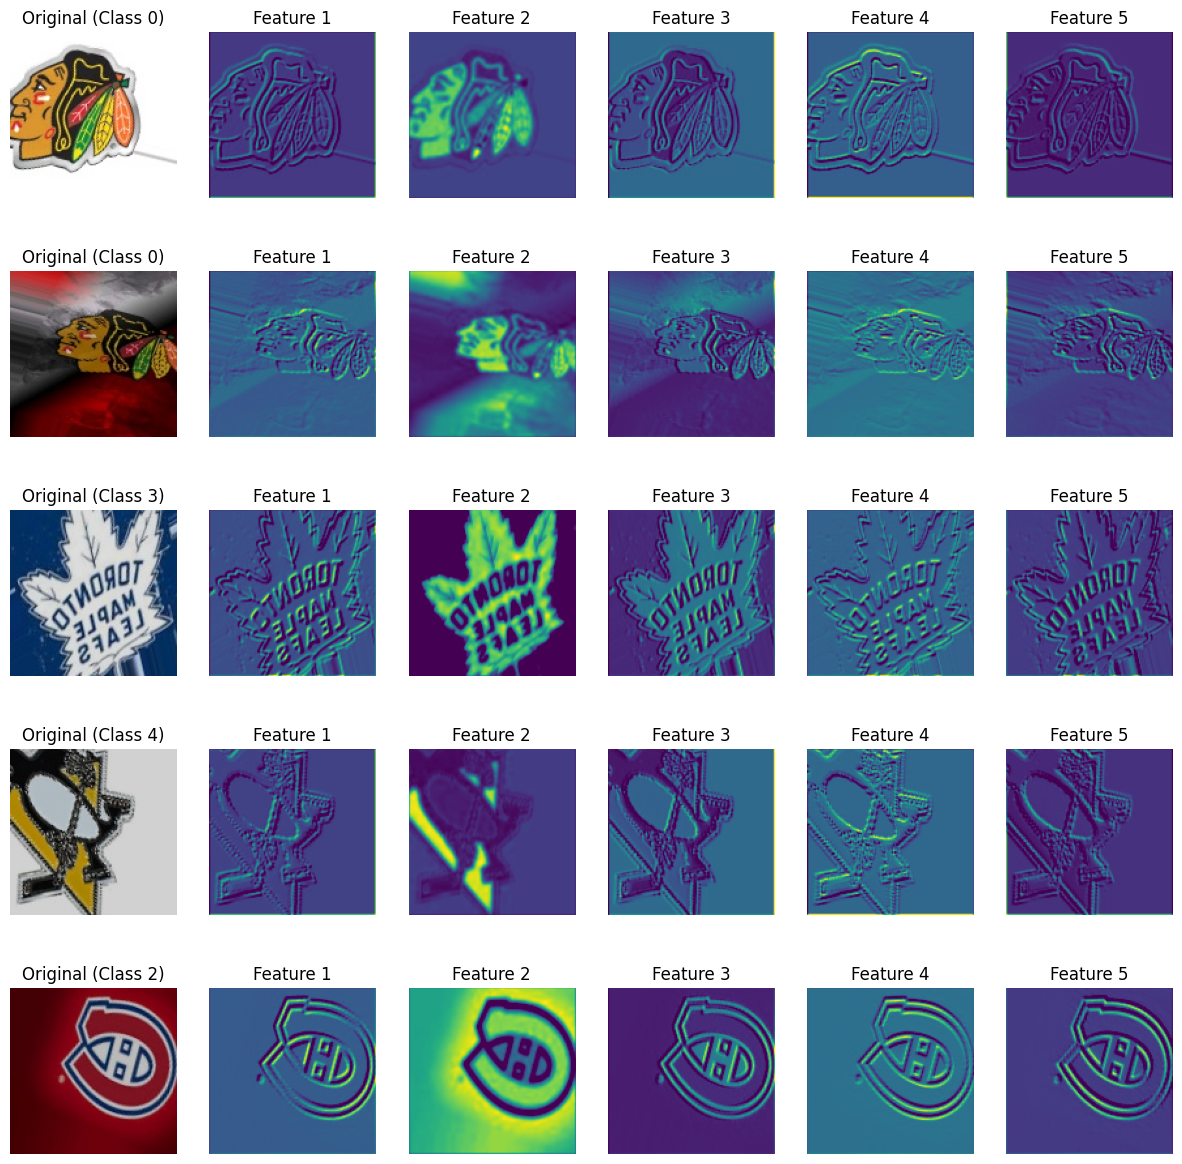

In [26]:
batch_img , batch_labels = next(train_data)
features = tf.keras.Model(inputs = model.input , outputs = model.layers[1].output)
fig, axes = plt.subplots(5, 6, figsize=(15, 3 * 5))

for i in range(min(5, len(batch_img))):
    axes[i, 0].imshow(batch_img[i])
    axes[i, 0].set_title(f'Original (Class {np.argmax(batch_labels[i])})')
    axes[i, 0].axis('off')

    # Extract feature maps
    exfeatures = features.predict(batch_img[i:i+1])

    # Show first 5 feature maps
    for j in range(5):
        axes[i, j + 1].imshow(exfeatures[0, :, :, j], cmap='viridis')
        axes[i, j + 1].set_title(f'Feature {j+1}')
        axes[i, j + 1].axis('off')
plt.show()


In [27]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau
model1.compile( optimizer = 'adam' , loss=tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy' , 'precision' , 'recall'])

In [28]:
callbacks = [ ModelCheckpoint('/content/best_nhl_model.h5',monitor='val_accuracy',
        save_best_only=True,mode='max',verbose=False),
              EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=False
    ),

    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=False )
]

In [30]:
hist = model1.fit(train_data , epochs = 1 , validation_data = test_data , callbacks = callbacks , verbose =0)



Training History:


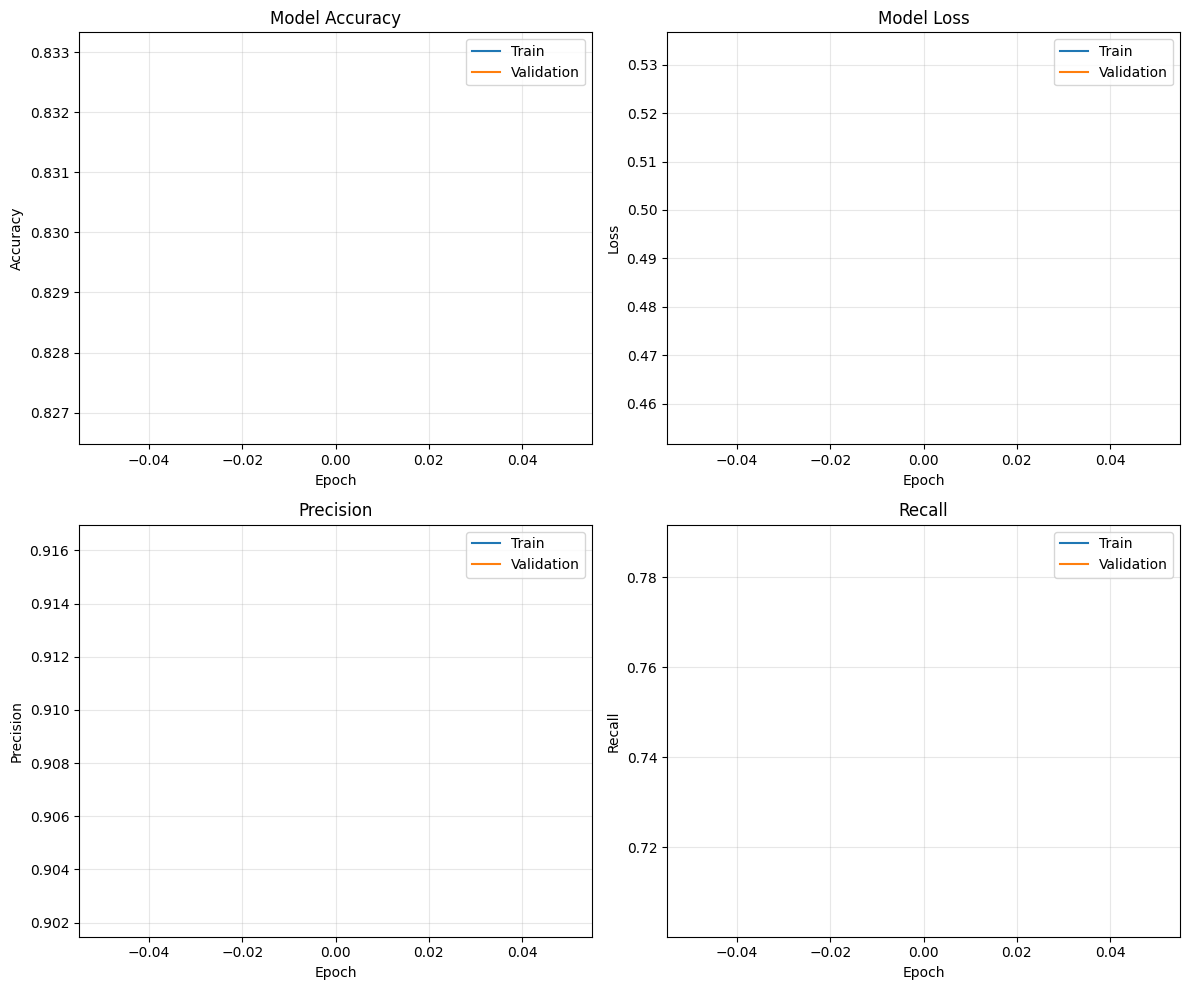


Model Evaluation

Final Performance:
  Training   - Accuracy: 0.9584, Loss: 0.2047
  Validation - Accuracy: 0.8330, Loss: 0.4555

Detailed Metrics:
  Precision: 0.9022
  Recall: 0.7875
  F1-Score: 0.8409

Generating predictions for confusion matrix...
17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step


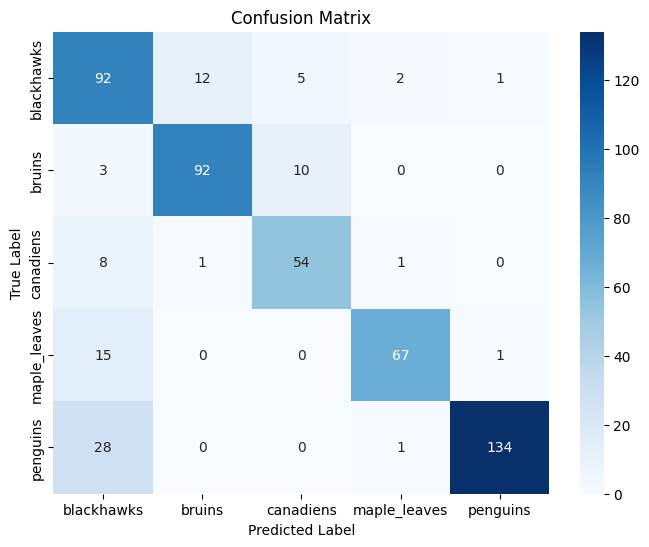


Classification Report:
              precision    recall  f1-score   support

  blackhawks       0.63      0.82      0.71       112
      bruins       0.88      0.88      0.88       105
   canadiens       0.78      0.84      0.81        64
maple_leaves       0.94      0.81      0.87        83
    penguins       0.99      0.82      0.90       163

    accuracy                           0.83       527
   macro avg       0.84      0.83      0.83       527
weighted avg       0.86      0.83      0.84       527



In [33]:
# Visualize training history
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report
def plot_training_history(hist):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Accuracy
    axes[0, 0].plot(hist.history['accuracy'], label='Train')
    axes[0, 0].plot(hist.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(hist.history['loss'], label='Train')
    axes[0, 1].plot(hist.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(hist.history['precision'], label='Train')
    axes[1, 0].plot(hist.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(hist.history['recall'], label='Train')
    axes[1, 1].plot(hist.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\nTraining History:")
plot_training_history(hist)

# Evaluate the model
print("\n" + "="*50)
print("Model Evaluation")
print("="*50)

# Get final metrics
train_loss, train_acc, train_prec, train_rec = model1.evaluate(train_data, verbose=0)
val_loss, val_acc, val_prec, val_rec = model1.evaluate(test_data, verbose=0)

print(f"\nFinal Performance:")
print(f"  Training   - Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"  Validation - Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"\nDetailed Metrics:")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1-Score: {2 * (val_prec * val_rec) / (val_prec + val_rec):.4f}")

# Generate predictions for confusion matrix
print("\nGenerating predictions for confusion matrix...")
test_data.reset()
predictions = model1.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print("="*50)
print(classification_report(y_true, y_pred,
                           target_names=list(train_data.class_indices.keys())))

Available metrics in history:
dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

Number of epochs trained: 1

Would you like to train for more epochs? Current training only has 1 epoch(s)
Training for more epochs to get better visualization...
Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9272 - loss: 0.2610 - precision: 0.9566 - recall: 0.8892

67/67 ━━━━━━━━━━━━━━━━━━━━ 455s 7s/step - accuracy: 0.9274 - loss: 0.2604 - precision: 0.9568 - recall: 0.8894 - val_accuracy: 0.8577 - val_loss: 0.3065 - val_precision: 0.8966 - val_recall: 0.8387 - learning_rate: 0.0010
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9708 - loss: 0.1222 - precision: 0.9828 - recall: 0.9559

67/67 ━━━━━━━━━━━━━━━━━━━━ 494s 7s/step - accuracy: 0.9708 - loss: 0.1220 - precision: 0.9828 - recall: 0.9560 - val_accuracy: 0.8994 - val_loss: 0.2561 - val_precision: 0.9152 - val_recall: 0.8805 - learning_rate: 0.0010
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 442s 7s/step - accuracy: 0.9814 - loss: 0.0769 - precision: 0.9871 - recall: 0.9759 - val_accuracy: 0.8937 - val_loss: 0.2475 - val_precision: 0.9107 - val_recall: 0.8899 - learning_rate: 0.0010
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9894 - loss: 0.0470 - precision: 0.9911 - recall: 0.9846

67/67 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.9894 - loss: 0.0470 - precision: 0.9911 - recall: 0.9846 - val_accuracy: 0.9203 - val_loss: 0.1918 - val_precision: 0.9359 - val_recall: 0.9146 - learning_rate: 0.0010
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9911 - loss: 0.0340 - precision: 0.9912 - recall: 0.9894

67/67 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - accuracy: 0.9911 - loss: 0.0340 - precision: 0.9912 - recall: 0.9894 - val_accuracy: 0.9317 - val_loss: 0.1687 - val_precision: 0.9364 - val_recall: 0.9222 - learning_rate: 0.0010
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9947 - loss: 0.0302 - precision: 0.9949 - recall: 0.9945

67/67 ━━━━━━━━━━━━━━━━━━━━ 493s 7s/step - accuracy: 0.9947 - loss: 0.0301 - precision: 0.9949 - recall: 0.9945 - val_accuracy: 0.9336 - val_loss: 0.1574 - val_precision: 0.9459 - val_recall: 0.9298 - learning_rate: 0.0010
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9959 - loss: 0.0212 - precision: 0.9972 - recall: 0.9959

67/67 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - accuracy: 0.9958 - loss: 0.0213 - precision: 0.9972 - recall: 0.9958 - val_accuracy: 0.9374 - val_loss: 0.1515 - val_precision: 0.9478 - val_recall: 0.9298 - learning_rate: 0.0010
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - accuracy: 0.9938 - loss: 0.0240 - precision: 0.9938 - recall: 0.9931 - val_accuracy: 0.9317 - val_loss: 0.1611 - val_precision: 0.9332 - val_recall: 0.9279 - learning_rate: 0.0010
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9960 - loss: 0.0173 - precision: 0.9962 - recall: 0.9945

67/67 ━━━━━━━━━━━━━━━━━━━━ 492s 7s/step - accuracy: 0.9960 - loss: 0.0172 - precision: 0.9962 - recall: 0.9945 - val_accuracy: 0.9412 - val_loss: 0.1392 - val_precision: 0.9463 - val_recall: 0.9355 - learning_rate: 0.0010
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9969 - loss: 0.0220 - precision: 0.9969 - recall: 0.9964

67/67 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.9969 - loss: 0.0219 - precision: 0.9969 - recall: 0.9964 - val_accuracy: 0.9564 - val_loss: 0.1183 - val_precision: 0.9598 - val_recall: 0.9526 - learning_rate: 0.0010

Training History Visualization:


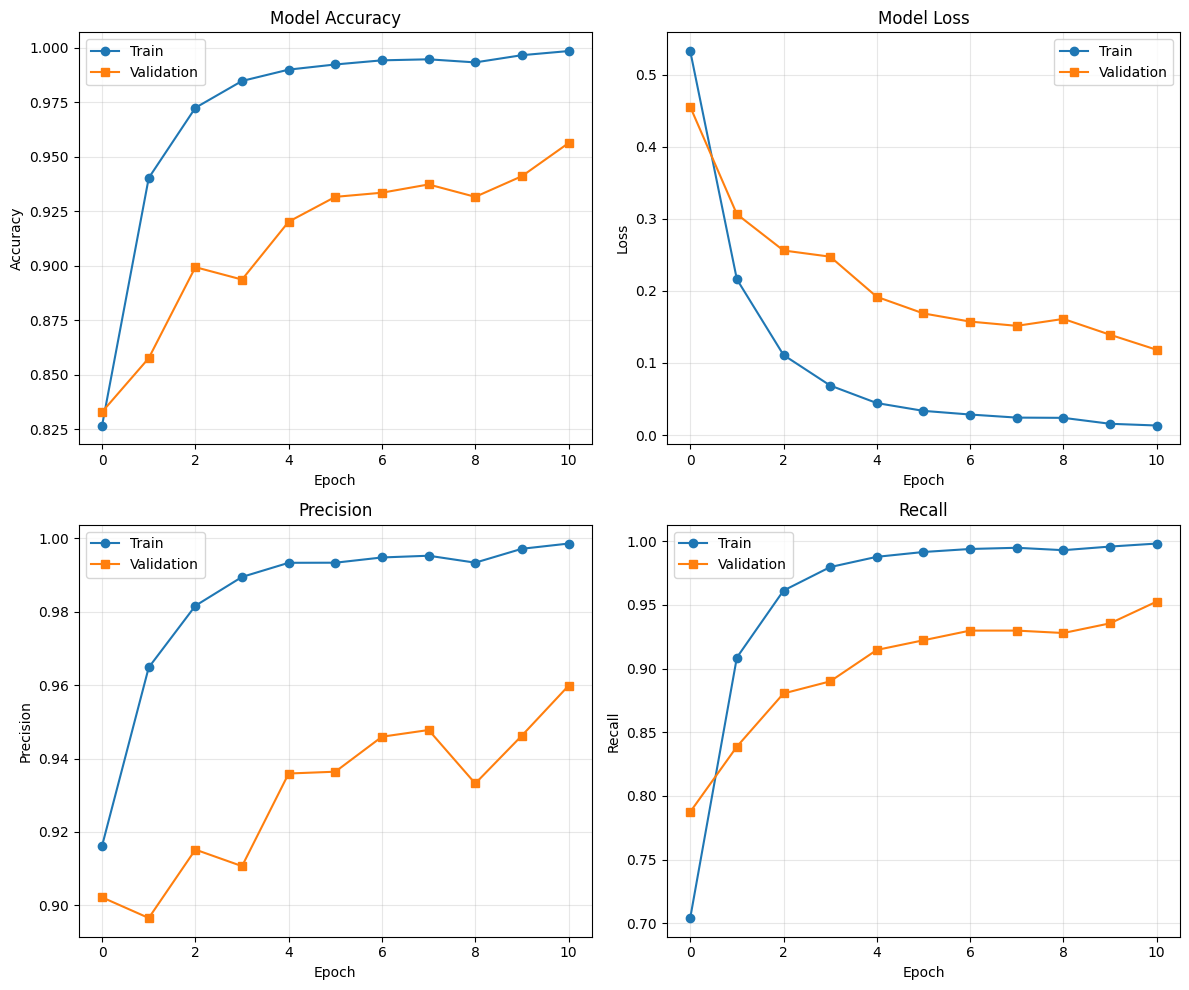


Model Evaluation

Final Performance:
  Validation - Accuracy: 0.9564, Loss: 0.1183

Generating predictions for confusion matrix...
17/17 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step


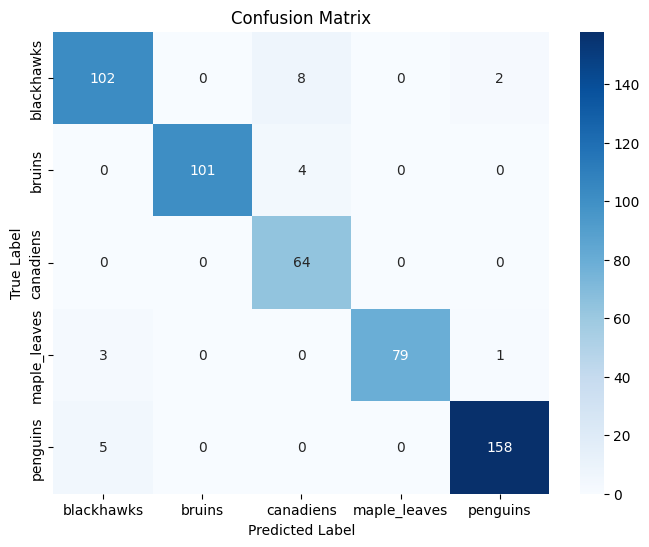


Classification Report:
              precision    recall  f1-score   support

  blackhawks       0.93      0.91      0.92       112
      bruins       1.00      0.96      0.98       105
   canadiens       0.84      1.00      0.91        64
maple_leaves       1.00      0.95      0.98        83
    penguins       0.98      0.97      0.98       163

    accuracy                           0.96       527
   macro avg       0.95      0.96      0.95       527
weighted avg       0.96      0.96      0.96       527



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# First, let's check what's actually in your history
print("Available metrics in history:")
print(hist.history.keys())
print("\nNumber of epochs trained:", len(hist.history['loss']))

# Fixed plotting function that handles single epoch and checks for metrics
def plot_training_history(hist):
    """Plot training metrics with error handling"""

    # Check which metrics are available
    available_metrics = hist.history.keys()

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Accuracy
    if 'accuracy' in available_metrics:
        axes[0, 0].plot(hist.history['accuracy'], 'o-', label='Train')
        if 'val_accuracy' in available_metrics:
            axes[0, 0].plot(hist.history['val_accuracy'], 's-', label='Validation')
        axes[0, 0].set_title('Model Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # Loss
    if 'loss' in available_metrics:
        axes[0, 1].plot(hist.history['loss'], 'o-', label='Train')
        if 'val_loss' in available_metrics:
            axes[0, 1].plot(hist.history['val_loss'], 's-', label='Validation')
        axes[0, 1].set_title('Model Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # Precision (might be 'precision_1' instead of 'precision')
    precision_key = 'precision' if 'precision' in available_metrics else 'precision_1'
    val_precision_key = 'val_precision' if 'val_precision' in available_metrics else 'val_precision_1'

    if precision_key in available_metrics:
        axes[1, 0].plot(hist.history[precision_key], 'o-', label='Train')
        if val_precision_key in available_metrics:
            axes[1, 0].plot(hist.history[val_precision_key], 's-', label='Validation')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Recall (might be 'recall_1' instead of 'recall')
    recall_key = 'recall' if 'recall' in available_metrics else 'recall_1'
    val_recall_key = 'val_recall' if 'val_recall' in available_metrics else 'val_recall_1'

    if recall_key in available_metrics:
        axes[1, 1].plot(hist.history[recall_key], 'o-', label='Train')
        if val_recall_key in available_metrics:
            axes[1, 1].plot(hist.history[val_recall_key], 's-', label='Validation')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# If you want to train for more epochs to see better graphs:
print("\nWould you like to train for more epochs? Current training only has", len(hist.history['loss']), "epoch(s)")

# Option 1: Train for more epochs (recommended)
if len(hist.history['loss']) < 5:
    print("Training for more epochs to get better visualization...")

    # Continue training from where you left off
    hist2 = model1.fit(
        train_data,
        epochs=10,  # Train for 10 more epochs
        validation_data=test_data,
        callbacks=callbacks,
        verbose=1
    )

    # Combine histories
    for key in hist.history.keys():
        hist.history[key].extend(hist2.history[key])

# Now plot with more data
print("\nTraining History Visualization:")
plot_training_history(hist)

# Rest of your evaluation code
print("\n" + "="*50)
print("Model Evaluation")
print("="*50)

# Get final metrics
evaluation_results = model1.evaluate(test_data, verbose=0)
val_loss = evaluation_results[0]
val_acc = evaluation_results[1]

print(f"\nFinal Performance:")
print(f"  Validation - Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Generate predictions for confusion matrix
print("\nGenerating predictions for confusion matrix...")
test_data.reset()
predictions = model1.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print("="*50)
print(classification_report(y_true, y_pred,
                           target_names=list(train_data.class_indices.keys())))


Random Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


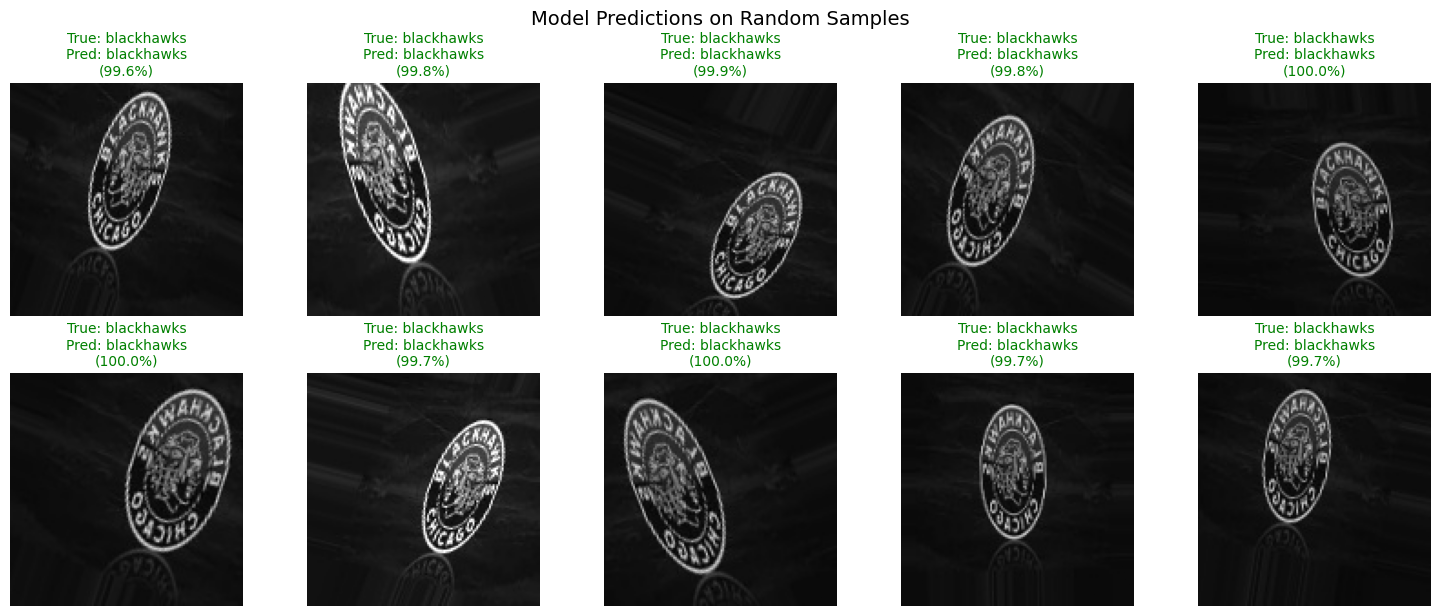


✓ Model saved as 'final_nhl_classifier.h5'

Model Information:
  Total parameters: 14,879,557
  Trainable parameters: 164,869
  Non-trainable parameters: 14,714,688

Testing on another batch of samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


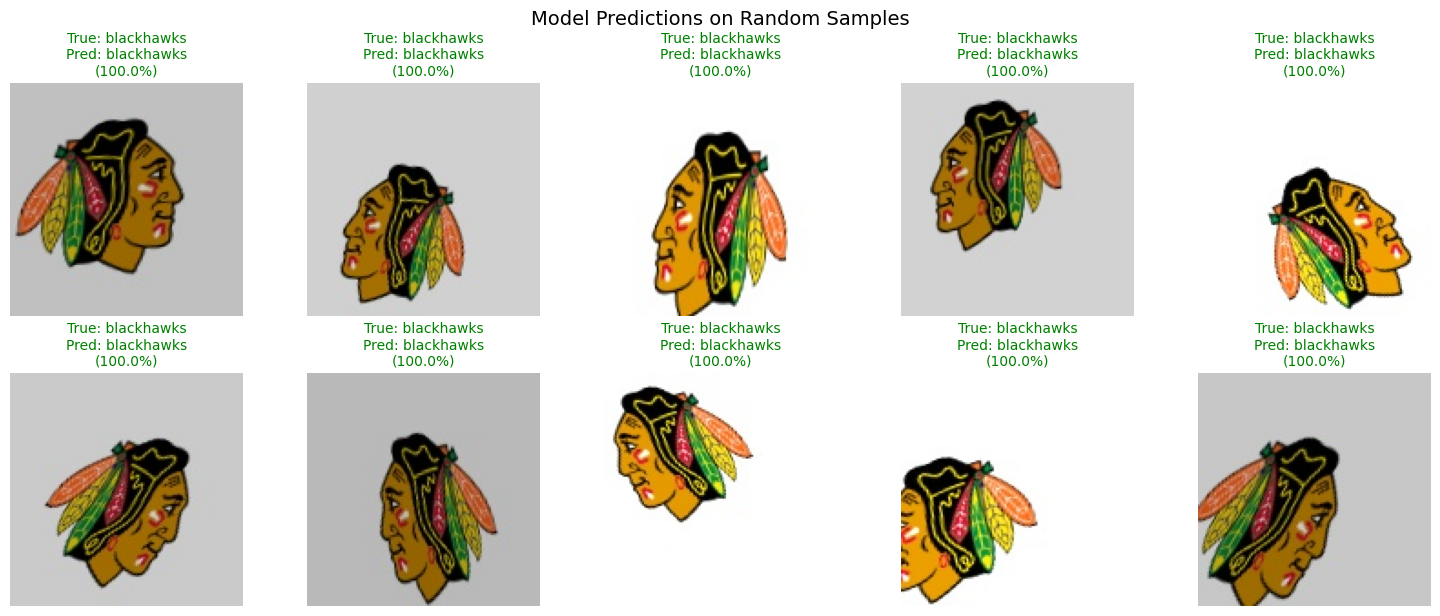


Model Confidence Analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


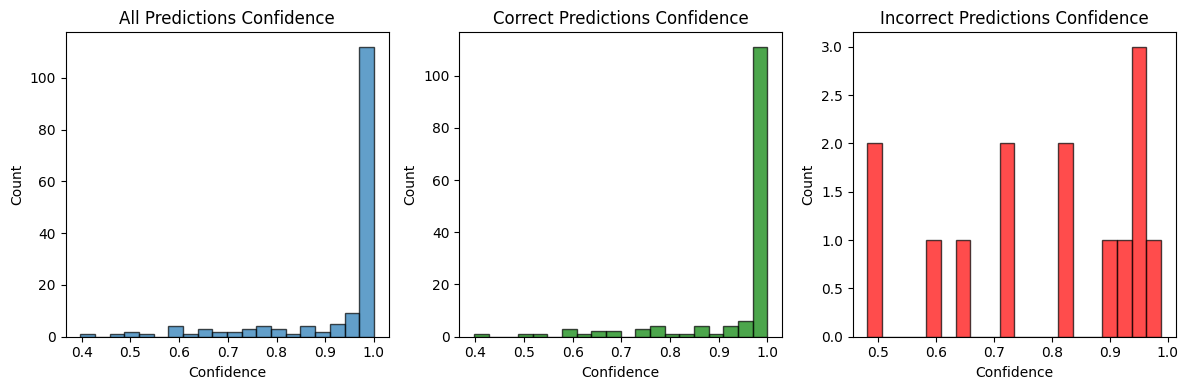

Average confidence - Correct: 0.946
Average confidence - Incorrect: 0.784


In [36]:
# Test on random samples
def test_random_samples(model, generator, num_samples=10):
    """Test model on random samples and visualize results"""
    batch_images, batch_labels = next(generator)
    predictions = model.predict(batch_images[:num_samples])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    class_names = list(generator.class_indices.keys())

    for i in range(min(num_samples, len(batch_images))):
        img = batch_images[i]
        true_label = class_names[np.argmax(batch_labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)',
                         color=color, fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, 10):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle('Model Predictions on Random Samples', y=1.02, fontsize=14)
    plt.show()

print("\nRandom Sample Predictions:")
test_random_samples(model1, test_data)

# Save the final model - using model1 consistently
model1.save('/content/final_nhl_classifier.h5')
print("\n✓ Model saved as 'final_nhl_classifier.h5'")

# Model size and complexity - using model1 consistently
print("\n" + "="*50)
print("Model Information:")
print(f"  Total parameters: {model1.count_params():,}")
print(f"  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model1.trainable_weights]):,}")
print(f"  Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model1.non_trainable_weights]):,}")

# Additional: Test with a fresh batch to ensure variety
print("\n" + "="*50)
print("Testing on another batch of samples:")
test_data.reset()  # Reset generator
test_random_samples(model1, test_data, num_samples=10)

# Optional: Show model's confidence distribution
def plot_confidence_distribution(model, generator, num_batches=5):
    """Plot distribution of model's prediction confidence"""
    all_confidences = []
    correct_confidences = []
    incorrect_confidences = []

    for _ in range(num_batches):
        batch_images, batch_labels = next(generator)
        predictions = model.predict(batch_images)

        for i in range(len(predictions)):
            confidence = np.max(predictions[i])
            all_confidences.append(confidence)

            true_label = np.argmax(batch_labels[i])
            pred_label = np.argmax(predictions[i])

            if true_label == pred_label:
                correct_confidences.append(confidence)
            else:
                incorrect_confidences.append(confidence)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(all_confidences, bins=20, edgecolor='black', alpha=0.7)
    plt.title('All Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(correct_confidences, bins=20, color='green', edgecolor='black', alpha=0.7)
    plt.title('Correct Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(incorrect_confidences, bins=20, color='red', edgecolor='black', alpha=0.7)
    plt.title('Incorrect Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    print(f"Average confidence - Correct: {np.mean(correct_confidences):.3f}")
    if incorrect_confidences:
        print(f"Average confidence - Incorrect: {np.mean(incorrect_confidences):.3f}")

print("\n" + "="*50)
print("Model Confidence Analysis:")
test_data.reset()
plot_confidence_distribution(model1, test_data)